<a href="https://colab.research.google.com/github/A-Wadhwani/ME597-Project/blob/prelim_results/UMass%20Solar%20data%20cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data loading and visualisation


In [1]:
#Loading the needed libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt




In [2]:
#loading in the needed data
data_df =  pd.read_csv('https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/prelim_results/Datasets/Power%20Data/UMass_PowerConsumption.csv', parse_dates=['Site Time'], )

In [3]:
#Checking if the data has been loaded properly
data_df.head(10)

,Site Time,UMASS Amherst - Robsham Visitors Center null,UMASS Amherst - Lot 44 Carport null,UMASS Amherst - Champions Center null,UMASS Amherst - Computer Science null,UMASS Amherst - Fine Arts Center null,UMASS Amherst - Recreation Center null,UMASS Amherst - University Police null,UMASS Amherst - Lot 25 Carport null
0,2017-01-01,80.5,0,0,0,0.0,0,0.0,0
1,2017-01-02,59.3,0,0,0,0.0,0,0.0,0
2,2017-01-03,22.8,34.629,0,0,0.0,0,0.0,0
3,2017-01-04,76.6,0,0,0,0.0,0,0.0,0
4,2017-01-05,224,0,0,0,0.0,0,0.0,0
5,2017-01-06,194.9,0,0,0,0.0,0,0.0,0
6,2017-01-07,22.8,53.598,0,0,0.0,0,0.0,0
7,2017-01-08,7.2,110.447,0,0,0.0,0,0.0,0
8,2017-01-09,9.9,101.987,0,0,0.0,0,0.0,0
9,2017-01-10,9.7,96.476,0,0,0.0,0,0.0,0


(array([267., 136., 133., 125., 127., 130., 130., 123., 124., 128.]),
 array([   0.,  122.,  244.,  366.,  488.,  610.,  732.,  854.,  976.,
        1098., 1220.]),
 <a list of 10 Patch objects>)

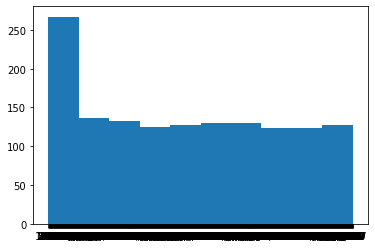

In [5]:
#Creating histograms to visualise the data
plt.hist(data_df['UMASS Amherst - Robsham Visitors Center null'])

In [ ]:
#Breaking up the date column into indivisual day, month and year columns
data_df['Day'] = [d.day for d in data_df['Site Time']]
data_df['Month'] = [d.month for d in data_df['Site Time']]
data_df['Year'] = [d.year for d in data_df['Site Time']]
data_df['Date'] = [d.date() for d in data_df['Site Time']]

In [ ]:
#Dropping rows from 2020 as no weather data is availible for that time as well as assigning the needed locations to a new data frame
data_new_df = data_df[data_df.Year != 2020].drop(['UMASS Amherst - Champions Center null','UMASS Amherst - Robsham Visitors Center null','UMASS Amherst - Lot 44 Carport null', 'UMASS Amherst - University Police null', 'UMASS Amherst - Lot 25 Carport null' ], axis=1)

In [ ]:
#Ensuring that the power production data are floats
data_new_df['UMASS Amherst - Computer Science null'] = data_new_df['UMASS Amherst - Computer Science null'].str.replace(',','').astype(float)
data_new_df['UMASS Amherst - Recreation Center null'] = data_new_df['UMASS Amherst - Recreation Center null'].str.replace(',','').astype(float)


In [ ]:
#Dividing all the power production values by the number of panel at the location to get a rough estimate of the power per panel
data_new_df['UMASS Amherst - Computer Science null'] = data_new_df['UMASS Amherst - Computer Science null'] / 421
data_new_df['UMASS Amherst - Fine Arts Center null'] = data_new_df['UMASS Amherst - Fine Arts Center null'] / 424
data_new_df['UMASS Amherst - Recreation Center null'] = data_new_df['UMASS Amherst - Recreation Center null'] / 660

In [ ]:
#dropping the now uneeded site time column
data_new_df = data_new_df.drop(['Site Time'], axis=1)

In [ ]:
#Dropping rows 0 values
data_new_df = data_new_df[(data_new_df != 0).all(1)]

In [ ]:
#Merge weather data and power data 
def merge_weather(df_power, weather_data='Datasets/Orlando_Weather.csv'):
    #Read data, drop unused columns and remove 0 values
    df_weather = pd.read_csv(weather_data)
    df_weather = df_weather.drop(columns=['Hour', 'Minute','Wind Direction'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']

    #Split into Y M and D
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']


    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

#    df_power[['Year', 'Month', 'Day']] = df_power.Date.str.split('-', expand=True).apply(pd.to_numeric)

    #Merge data together
    df_merge = df_weather.merge(df_power, left_on=('Year', 'Month', 'Day'), 
                                right_on=('Year', 'Month', 'Day'), how = 'inner', suffixes=('_left','_right'))
    df_merge = df_merge.rename(columns={'DNI':'DNI Mean'})

    return df_merge

In [ ]:
#Creating the final dataset with combined power production and cleaned weather data
final_df = merge_weather(data_new_df,weather_data='https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/prelim_results/Datasets/Weather%20Data/Amherst_Weather.csv')

In [ ]:
#Checking if the data has been combined properly
final_df.head()

,Year,Month,Day,DHI,DNI Max,DNI Min,DNI Mean,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temp Max,Temp Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Pressure,UMASS Amherst - Computer Science null,UMASS Amherst - Fine Arts Center null,UMASS Amherst - Recreation Center null,Date
0,2017,2,3,76.100000,808,194,606.200000,305.800000,86.300000,697.200000,350.800000,-2.0,-8.0,0.480000,0.383400,67.023000,-3.500000,1000.000000,1.061948,1.411040,1.095000,2017-02-03
1,2017,2,4,88.100000,874,286,676.200000,345.400000,88.200000,694.800000,355.100000,-3.0,-7.0,0.600000,0.363900,67.680000,-3.900000,1000.000000,1.409026,1.852061,1.453818,2017-02-04
2,2017,2,5,122.888889,693,31,356.222222,278.333333,117.666667,615.888889,370.555556,1.0,-5.0,0.566667,0.886000,76.916667,-1.000000,992.222222,0.810475,0.826453,0.818667,2017-02-05
3,2017,2,6,77.666667,927,4,649.222222,336.444444,72.222222,752.111111,373.000000,0.0,-5.0,0.611111,0.731889,61.147778,-1.777778,1000.000000,1.234228,1.570186,1.250591,2017-02-06
4,2017,2,8,109.800000,850,33,466.400000,295.700000,96.600000,657.000000,360.400000,5.0,1.0,0.500000,1.026600,98.111000,2.800000,985.000000,0.657363,1.043031,0.712076,2017-02-08


In [ ]:
#putting the final values into a csv 
final_df.to_csv('Umass_total_data.csv')